In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres" # change this
SQL_IP = "localhost"
PORT = 5432
DATABASE = "project_2_crowrdfunding" # change this

In [6]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [7]:
#INSPECT

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(50)
last_name VARCHAR(50)
email VARCHAR(100)
last_updated TIMESTAMP

campaign
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(200)
goal NUMERIC
pledged NUMERIC
outcome VARCHAR(50)
backers_count INTEGER
country VARCHAR(50)
currency VARCHAR(10)
launch_date DATE
end_date DATE
category_id VARCHAR(10)
subcategory_id VARCHAR(10)
last_updated TIMESTAMP

category
category_id VARCHAR(10)
category VARCHAR(20)
last_updated TIMESTAMP

subcategory
subcategory_id VARCHAR(10)
subcategory VARCHAR(20)
last_updated TIMESTAMP



In [8]:
# Read in csv
df = pd.read_csv("Resources/campaign_cleaned.csv")
df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13,2021-03-01,cat1,subcat1
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25,2021-05-25,cat2,subcat2
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17,2021-12-30,cat3,subcat3
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21,2022-01-17,cat2,subcat2
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21,2021-08-23,cat4,subcat4


In [9]:
# cleaning up columns
df.columns = [x.lower() for x in df.columns]
df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13,2021-03-01,cat1,subcat1
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25,2021-05-25,cat2,subcat2
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17,2021-12-30,cat3,subcat3
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21,2022-01-17,cat2,subcat2
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21,2021-08-23,cat4,subcat4


In [10]:
#Reading in to sql
df.to_sql("campaign_cleaned", schema="public", con=engine, index=False, if_exists="append", method="multi")

1000

In [20]:
#SQL Query 1
sql_query = """
SELECT country, COUNT(*) AS count
FROM campaign_cleaned
GROUP BY country
ORDER BY count DESC;
"""

In [21]:
#Save results as df
country_counts_df = pd.read_sql_query(sql_query, engine)

In [22]:
#Check df
country_counts_df

,country,count
0,US,763
1,GB,48
2,IT,48
3,CA,44
4,AU,43
5,DK,31
6,CH,23


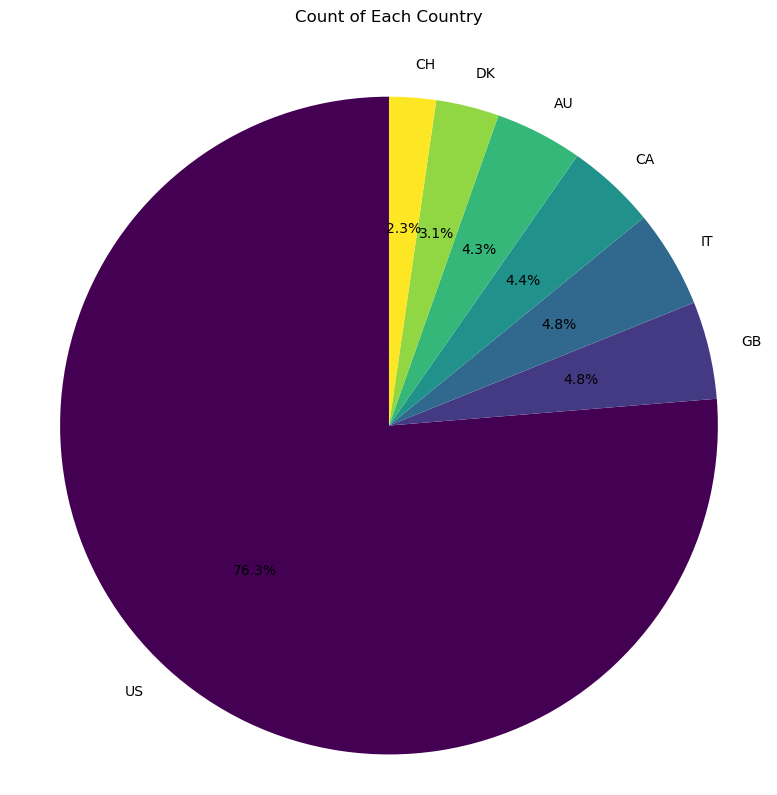

In [48]:
# Determine the starting angle for the largest slice
max_count_index = country_counts_df['count'].idxmax()
startangle = 90 - (360 * max_count_index / len(country_counts_df))

#gradient color
colors = plt.cm.viridis(np.linspace(0, 1, len(country_counts_df)))

#pie chart showing the count of projects in the countires
plt.figure(figsize=(8, 8))
plt.pie(country_counts_df['count'], labels=country_counts_df['country'], autopct='%1.1f%%', startangle=startangle, colors=colors)
plt.title('Count of Each Country', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.tight_layout()  # Adjust layout
plt.show()

In [34]:
#SQL query 2
sql_query = """
SELECT company_name, outcome, backers_count
FROM campaign_cleaned
WHERE outcome = 'failed' AND backers_count < 30;
"""

In [35]:
#save results as df
result = pd.read_sql_query(sql_query, engine)

In [36]:
#save results as df
result_df = pd.read_sql_query(sql_query, engine)

In [37]:
#check df
result_df.head()

,company_name,outcome,backers_count
0,"Baldwin, Riley and Jackson",failed,0
1,"Mcdonald, Gonzalez and Ross",failed,24
2,"Ortiz, Coleman and Mitchell",failed,18
3,"Perez, Johnson and Gardner",failed,27
4,"Best, Carr and Williams",failed,15


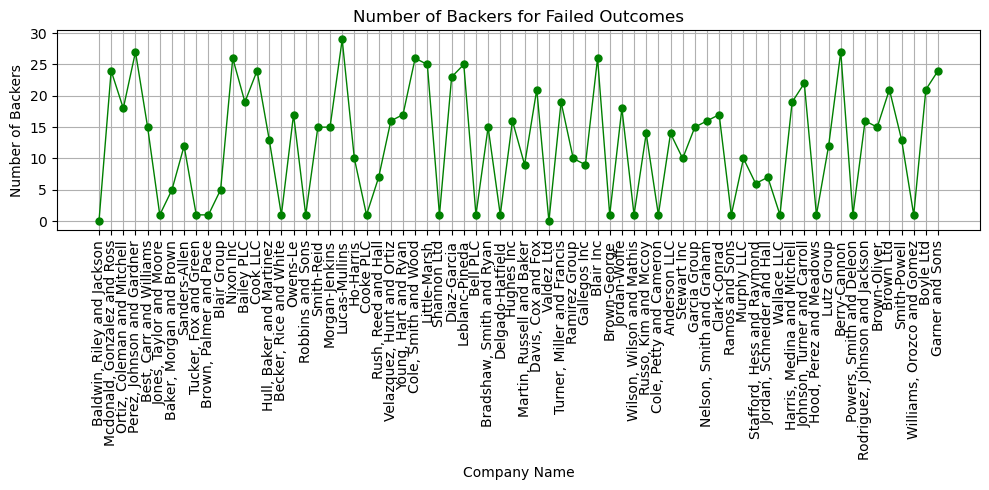

In [47]:
#Line chart of Companies with failed projects that had less than 30 Backers
plt.figure(figsize=(10, 5))
plt.plot(result_df['company_name'], result_df['backers_count'], marker='o', linestyle='-', color='green', markersize=5, linewidth=1)
plt.title('Number of Backers for Failed Outcomes')
plt.xlabel('Company Name')
plt.ylabel('Number of Backers')
plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
plt.grid()
plt.tight_layout()  # Adjust layout for better fitting
plt.show()